# Assessment Referral Model

In [1]:
import numpy as np
import pandas as pd
import simpy
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

sns.set()

simpy.__version__

'4.0.1'

In [2]:
from sim_utility.distributions import (Bernoulli, Discrete, Poisson, 
                                       generate_seed_vector)

In [3]:
ANNUAL_DEMAND = 16328
LOW_PRIORITY_MIN_WAIT = 3
HIGH_PRIORITY_MIN_WAIT = 1

PROP_HIGH_PRORITY= 0.15
PROP_CARVE_OUT = 0.15

#target in working days
TARGET_HIGH = 5
TARGET_LOW = 20

ANNUAL_DEMAND / 52 / 5

62.8

In [4]:
class Clinic():
    '''
    A clinic has a probability of refering patients
    to another service after triage.
    '''
    def __init__(self, prob_referral_out, random_seed=None):
        
        #prob patient is referred to another service
        self.prob_referral_out = prob_referral_out        
        self.ref_out_dist = Bernoulli(prob_referral_out, random_seed)


In [5]:
class ScenarioArgs():
    '''
    Arguments represent a configuration of the simulation model.
    '''
    def __init__(self, run_length, seeds=None): 
        
        if seeds is None:
            self.seeds = [None for i in range(100)]
        else:
            self.seeds = seeds
        
        self.debug = []
        
        self.run_length = run_length
        self.clinic_demand = pd.read_csv('data/referrals.csv')
        self.weekly_slots = pd.read_csv('data/shifts.csv')
        self.pooling = pooling = pd.read_csv('data/partial_pooling.csv')
        
        #used to reduce runtime from pandas overhead
        self.pooling_np = self.pooling.to_numpy().T[1:].T
        
        #These represent the 'diaries' of bookings
        
        # 1. carve out
        self.carve_out_slots = self.create_carve_out(run_length, 
                                                     self.weekly_slots)
        
        # 2. available slots and one for the bookings.
        self.available_slots = self.create_slots(self.run_length, 
                                                 self.weekly_slots)
        
        # 3. the bookings which can be used to calculate slot utilisation
        self.bookings = self.create_bookings(self.run_length,
                                             len(self.weekly_slots.columns))
        
        #sampling distributions
        self.arrival_dist = Poisson(ANNUAL_DEMAND / 52 / 5, 
                                    random_seed=self.seeds[0])
        self.priority_dist = Bernoulli(PROP_HIGH_PRORITY, 
                                       random_seed=self.seeds[1])
        
        #create a distribution for sampling a patients local clinic.
        elements = [i for i in range(len(self.clinic_demand))]
        probs = self.clinic_demand['prop'].to_numpy()
        self.clinic_dist = Discrete(elements, probs, random_seed=self.seeds[2])
        
        #create a list of clinic objects
        self.clinics = []
        for i in range(len(self.clinic_demand)):
            clinic = Clinic(self.clinic_demand['referred_out'].iloc[i],
                            random_seed=self.seeds[i+3])
            self.clinics.append(clinic)
                
    def create_carve_out(self, run_length, capacity_template):

        #proportion of total capacity carved out for high priority patients
        priority_template = (capacity_template * PROP_CARVE_OUT).round().astype(np.uint8)    
            
        priority_slots = priority_template.copy()
        
        #longer than run length as patients will need to book ahead
        for day in range(int(run_length*1.5)):
            priority_slots = pd.concat([priority_slots, priority_template.copy()], 
                                        ignore_index=True)

        priority_slots.index.rename('day', inplace=True)
        return priority_slots
    
    def create_slots(self, run_length, capacity_template):
        
        priority_template = (capacity_template * PROP_CARVE_OUT).round().astype(np.uint8)  
        open_template = capacity_template - priority_template       
        available_slots = open_template.copy()
        
        #longer than run length as patients will need to book ahead
        for day in range(int(run_length*1.5)):
            available_slots = pd.concat([available_slots, open_template.copy()], 
                                         ignore_index=True)

        available_slots.index.rename('day', inplace=True)
        return available_slots
    
    def create_bookings(self, run_length, clinics):
        bookings = np.zeros(shape=(5, clinics), dtype=np.uint8)

        columns = [f'clinic_{i}' for i in range(1, clinics+1)]
        bookings_template = pd.DataFrame(bookings, columns=columns)
        
        bookings = bookings_template.copy()
        
        #longer than run length as patients will need to book ahead
        for day in range(int(run_length*1.5)):
            bookings = pd.concat([bookings, bookings_template.copy()], 
                                 ignore_index=True)

        bookings.index.rename('day', inplace=True)
        return bookings

In [6]:
class LowPriorityBooker():
    '''
    Low prioity booking process
    
    Low priority patients only have access to public slots and have a minimum
    waiting time (e.g. 3 days before a slot can be used.)
    '''
    def __init__(self, args):
        self.args = args
        self.min_wait = LOW_PRIORITY_MIN_WAIT
        self.priority = 1
        
    def find_slot(self, t, clinic_id):
        '''
        Finds a slot in a diary of available slot

        Params:
        ------
        t: int,
            time t in days

        clinic_id: int
            clinic id is the index  of the clinic column in diary

        min_wait: int
            minimum number days a patient must wait before attending a booking
        '''

        #get the clinic slots from t+min_wait days forward
        #clinic_slots = self.args.available_slots[self.args.available_slots.columns[clinic_id]].iloc[t+self.min_wait:]
        clinic_slots = self.args.available_slots.loc[t+self.min_wait:, 
                                self.args.available_slots.columns[clinic_id]]

        
        #find closest day with 1 or more slots + booked clinic
        return clinic_slots[clinic_slots > 0].index[0] - t, clinic_id
    
    
    def book_slot(self, booking_t, clinic_id):
        '''
        Book a slot on day t for clinic c

        A slot is removed from args.available_slots
        A appointment is recorded in args.bookings.iat

        Params:
        ------
        booking_t: int
            Day of booking

        clinic_id: int
            the clinic identifier
        '''
        #one less public available slot
        self.args.available_slots.iat[booking_t, clinic_id] -= 1

        #one more patient waiting
        self.args.bookings.iat[booking_t, clinic_id] += 1

In [7]:
class LowPriorityPooledBooker():
    '''
    Low prioity booking process for POOLED clinics.
    
    Low priority patients only have access to public slots and have a minimum
    waiting time (e.g. 3 days before a slot can be used.)
    '''
    def __init__(self, args):
        self.args = args
        self.min_wait = LOW_PRIORITY_MIN_WAIT
        self.priority = 1
        
    def find_slot(self, t, clinic_id):
        '''
        Finds a slot in a diary of available slot

        Params:
        ------
        t: int,
            time t in days

        clinic_id: int
            home clinic id is the index  of the clinic column in diary

        '''
        
        #get the clinics that are pooled with this one.
        clinic_options = \
           self.args.pooling.iloc[clinic_id][self.args.pooling.iloc[clinic_id] == 1].index
        
        #get the clinic slots t+min_wait forward for the pooled clinics
        clinic_slots = self.args.available_slots.loc[t+self.min_wait:, 
                                                clinic_options]
        
        #get the earliest slots 
        earliest_slots = clinic_slots[clinic_slots.sum(axis=1) > 0].iloc[0]
        
        #get the earliest day number (its the name of the series)
        best_t = int(earliest_slots.name)
        
        #get the name (str) of the clinic with the earliest slot
        best_clinic = earliest_slots[earliest_slots > 0].index[0]
        
        #convert name to clinic id
        best_clinic_id = np.where(self.args.available_slots.columns 
                                  == best_clinic)[0][0]
        
        #return (waiting_time, clinic_id)
        return best_t - t, best_clinic_id
    
    
    def book_slot(self, booking_t, clinic_id):
        '''
        Book a slot on day t for clinic c

        A slot is removed from args.available_slots
        A appointment is recorded in args.bookings.iat

        Params:
        ------
        booking_t: int
            Day of booking

        clinic_id: int
            the clinic identifier
        '''
        #one less public available slot
        self.args.available_slots.iat[booking_t, clinic_id] -= 1

        #one more patient waiting
        self.args.bookings.iat[booking_t, clinic_id] += 1

In [8]:
class HighPriorityBooker():
    '''
    High prioity booking process
    
    High priority patients are a minority, but require urgent access to services.
    They booking process has access to public slots and carve out slots.  High 
    priority patient still have a delay before booking, but this is typically
    small e.g. next day slots.
    '''
    def __init__(self, args):
        '''
        Constructor
        
        Params:
        ------
        args: ScenarioArgs
            simulation input parameters including the booking sheets
        '''
        self.args = args
        self.min_wait = 1
        self.priority = 2
        
    def find_slot(self, t, clinic_id):
        '''
        Finds a slot in a diary of available slots
        
        High priority patients have access to both 
        public slots and carve out reserved slots.

        Params:
        ------
        t: int,
            time t in days

        clinic_id: int
            clinic id is the index  of the clinic column in diary
        '''    
        #get the clinic slots from t+min_wait days forward

        #priority slots
        #priority_slots = self.args.carve_out_slots[self.args.carve_out_slots.columns[clinic_id]].iloc[t+self.min_wait:]
        priority_slots = self.args.carve_out_slots.loc[t+self.min_wait:, 
                               self.args.carve_out_slots.columns[clinic_id]]
        
        #public slots
        #public_slots = self.args.available_slots[self.args.available_slots.columns[clinic_id]].iloc[t+self.min_wait:]
        public_slots = self.args.available_slots.loc[t+self.min_wait:, 
                           self.args.available_slots.columns[clinic_id]]
            
        #total slots
        clinic_slots = priority_slots + public_slots

        #find closest day with 1 or more slots.
        return clinic_slots[clinic_slots > 0].index[0] - t, clinic_id
    
    def book_slot(self, booking_t, clinic_id):
        '''
        Book a slot on day t for clinic c

        A slot is removed from args.carve_out_slots or
        args.available_slots if required.
        
        A appointment is recorded in args.bookings.iat

        Params:
        ------
        booking_t: int
            Day of booking

        clinic_id: int
            the clinic identifier

        '''
        #take carve out slot first
        if self.args.carve_out_slots.iat[booking_t, clinic_id] > 0:
            self.args.carve_out_slots.iat[booking_t, clinic_id] -= 1
        else:
            #one less public available slot
            self.args.available_slots.iat[booking_t, clinic_id] -= 1

        #one more booking...
        self.args.bookings.iat[booking_t, clinic_id] += 1

In [9]:
class LowPriorityPooledBookerNumPy():
    '''
    Low prioity booking process for POOLED clinics.
    
    Low priority patients only have access to public slots and have a minimum
    waiting time (e.g. 3 days before a slot can be used.)
    
    NUMPY IMPLEMENTATION.
    '''
    def __init__(self, args):
        self.args = args
        self.min_wait = LOW_PRIORITY_MIN_WAIT
        self.priority = 1
        
        
    def find_slot(self, t, clinic_id):
        '''
        Finds a slot in a diary of available slot

        Params:
        ------
        t: int,
            time t in days

        clinic_id: int
            home clinic id is the index  of the clinic column in diary

        '''
        #to reduce runtime - drop down to numpy...
        available_slots_np = self.args.available_slots.to_numpy()
                
        #get the clinics that are pooled with this one.
        clinic_options = np.where(self.args.pooling_np[clinic_id] == 1)[0]
        
        #get the clinic slots t+min_wait forward for the pooled clinics
        clinic_slots = available_slots_np[t+self.min_wait:, clinic_options]
                
        #get the earliest day number (its the name of the series)
        best_t = np.where((clinic_slots.sum(axis=1) > 0))[0][0]
        
        #get the index of the best clinic option.
        best_clinic_idx = clinic_options[clinic_slots[best_t, :] > 0][0]
        
        #return (waiting_time, clinic_id)
        return best_t + self.min_wait, best_clinic_idx
    
    
    def book_slot(self, booking_t, clinic_id):
        '''
        Book a slot on day t for clinic c

        A slot is removed from args.available_slots
        A appointment is recorded in args.bookings.iat

        Params:
        ------
        booking_t: int
            Day of booking

        clinic_id: int
            the clinic identifier
        '''
        #one less public available slot
        self.args.available_slots.iat[booking_t, clinic_id] -= 1

        #one more patient waiting
        self.args.bookings.iat[booking_t, clinic_id] += 1

In [10]:
class HighPriorityBookerNumPy():
    '''
    High prioity booking process
    
    High priority patients are a minority, but require urgent access to services.
    They booking process has access to public slots and carve out slots.  High 
    priority patient still have a delay before booking, but this is typically
    small e.g. next day slots.
    '''
    def __init__(self, args):
        '''
        Constructor
        
        Params:
        ------
        args: ScenarioArgs
            simulation input parameters including the booking sheets
        '''
        self.args = args
        self.min_wait = 1
        self.priority = 2
        
    def find_slot(self, t, clinic_id):
        '''
        Finds a slot in a diary of available slots
        
        High priority patients have access to both 
        public slots and carve out reserved slots.

        Params:
        ------
        t: int,
            time t in days

        clinic_id: int
            clinic id is the index  of the clinic column in diary
        '''    
        
        #to reduce runtime - maybe...
        available_slots_np = self.args.available_slots.to_numpy()
        carve_out_slots_np = self.args.carve_out_slots.to_numpy()
        
        #get the clinic slots from t+min_wait days forward
        #priority slots
        priority_slots = carve_out_slots_np[t+self.min_wait:, clinic_id]
        
        #public slots
        public_slots = available_slots_np[t+self.min_wait:, clinic_id]
            
        #total slots
        clinic_slots = priority_slots + public_slots
    
        #find closest day with 1 or more slots + booked clinic
        return np.argmax(clinic_slots > 0) + self.min_wait, clinic_id
    
    def book_slot(self, booking_t, clinic_id):
        '''
        Book a slot on day t for clinic c

        A slot is removed from args.carve_out_slots or
        args.available_slots if required.
        
        A appointment is recorded in args.bookings.iat

        Params:
        ------
        booking_t: int
            Day of booking

        clinic_id: int
            the clinic identifier

        '''
        #take carve out slot first
        if self.args.carve_out_slots.iat[booking_t, clinic_id] > 0:
            self.args.carve_out_slots.iat[booking_t, clinic_id] -= 1
        else:
            #one less public available slot
            self.args.available_slots.iat[booking_t, clinic_id] -= 1

        #one more booking...
        self.args.bookings.iat[booking_t, clinic_id] += 1

In [11]:
class LowPriorityBookerNumPy():
    '''
    Low prioity booking process
    
    Low priority patients only have access to public slots and have a minimum
    waiting time (e.g. 3 days before a slot can be used.)
    '''
    def __init__(self, args):
        self.args = args
        self.min_wait = LOW_PRIORITY_MIN_WAIT
        self.priority = 1
        
    def find_slot(self, t, clinic_id):
        '''
        Finds a slot in a diary of available slot

        Params:
        ------
        t: int,
            time t in days

        clinic_id: int
            clinic id is the index  of the clinic column in diary

        min_wait: int
            minimum number days a patient must wait before attending a booking
        '''
        #to reduce runtime - maybe...
        available_slots_np = self.args.available_slots.to_numpy()
                
        #get the clinic slots t+min_wait forward for the pooled clinics
        clinic_slots = available_slots_np[t+self.min_wait:, clinic_id]
        
        #find closest day with 1 or more slots + booked clinic
        return np.argmax(clinic_slots > 0) + self.min_wait, clinic_id
    
    
    def book_slot(self, booking_t, clinic_id):
        '''
        Book a slot on day t for clinic c

        A slot is removed from args.available_slots
        A appointment is recorded in args.bookings.iat

        Params:
        ------
        booking_t: int
            Day of booking

        clinic_id: int
            the clinic identifier
        '''
        #one less public available slot
        self.args.available_slots.iat[booking_t, clinic_id] -= 1

        #one more patient waiting
        self.args.bookings.iat[booking_t, clinic_id] += 1

In [36]:
class PatientReferral(object):
    '''
    Patient referral process
    
    Find an appropraite asessment slot for the patient.
    Schedule an assessment for that day.
    
    '''
    def __init__(self, env, args, referral_t, home_clinic, booker):
        self.env = env
        self.args = args
        self.referral_t = referral_t
        self.home_clinic = home_clinic
        self.booked_clinic = home_clinic
        self.booker = booker
                
        #metrics 
        self.waiting_time = None
    
    @property
    def priority(self):
        return self.booker.priority
    
    def assess(self):
        #1. book slot at appropriate clinic
        #2. sample DNA
        #3. schedule the process to complete at that time.
        
        #get slot for clinic
        waiting_time, self.booked_clinic = \
            self.booker.find_slot(self.referral_t, self.home_clinic)
        
        #book slot at clinic = time of referral + waiting_time
        self.booker.book_slot(waiting_time + self.referral_t, 
                              self.booked_clinic)

        #wait for appointment
        yield self.env.timeout(waiting_time)
        
        self.waiting_time = waiting_time
        

In [37]:
class AssessmentReferralModel(object):
    '''
    Implements the Mental Wellbeing and Access 'Assessment Referral'
    model in Pitt, Monks and Allen (2015). https://bit.ly/3j8OH6y
    
    Patients arrive at random and in proportion to the regional team.
    
    Patients may be seen by any team identified by a pooling matrix.  
    This includes limiting a patient to only be seen by their local team.  
    
    The model reports average waiting time and can be used to compare 
    full, partial and no pooling of appointments.
    
    '''
    def __init__(self, env, args):
        '''
        Params:
        ------
        env: simpy.Environment
        
        args: ScenarioArgs
            Arguments for the simulation model
    
        '''
        self.env = env
        self.args = args
        
        #list of patients referral processes 
        self.referrals = []
    
    def generate_arrivals(self):
        '''
        
        Time slicing simulation.  The model steps forward by a single
        day and simulates the number of arrivals from a Poisson
        distribution.  The following process is then applied.
        
        1. Sample the region of the referral
        2. Triage - is an appointment made for the patient or are they referred
        to another service?
        3. A referral process is initiated for the patient.
        
        '''
        #loop a day at a time.
        for t in itertools.count():
            
            #total number of referrals today
            n_referrals = self.args.arrival_dist.sample()
            
            #loop through all referrals recieved that day
            for i in range(n_referrals):
                
                #sample clinic based on empirical proportions
                clinic_id = self.args.clinic_dist.sample()
                clinic = self.args.clinics[clinic_id]
                
                #triage patient and refer out of system if appropraite
                referred_out = clinic.ref_out_dist.sample()
                
                #if patient is accepted to clinic
                if referred_out == 0: 
                
                    #is patient high priority?
                    high_priority = self.args.priority_dist.sample()
                
                    if high_priority == 1:
                        booker = HighPriorityBookerNumPy(self.args)
                    else:
                        if self.args.pooling:
                            booker = LowPriorityPooledBookerNumPy(self.args)
                        else:
                            booker = LowPriorityBookerNumPy(self.args)
                
                    #create referral to that clinic
                    patient = PatientReferral(self.env, self.args, t, 
                                              clinic_id, booker)
                    
                    #start a referral assessment process for patient.
                    self.env.process(patient.assess())
                                        
                    #only collect results after warm-up complete
                    if self.env.now > self.args.warm_up_period:
                        #store patient for calculating waiting time stats at end.
                        self.referrals.append(patient)
            
            #timestep by one day
            yield self.env.timeout(1)
            
    def process_run_results(self):
        
        results_all = [p.waiting_time for p in self.referrals 
               if not p.waiting_time is None]

        results_low = [p.waiting_time for p in self.referrals 
                       if not (p.waiting_time is None) and p.priority == 1]

        results_high = [p.waiting_time for p in self.referrals 
                       if (not p.waiting_time is None) and p.priority == 2]
        
        self.results_all = np.array(results_all)
        self.results_low = np.array(results_low)
        self.results_high = np.array(results_high)

In [40]:
def single_run(rep=0, seed_vector=None):
    
    env = simpy.Environment()
    args = ScenarioArgs(RUN_LENGTH, seed_vector)
    args.warm_up_period = WARM_UP
    args.pooling = POOLING
    
    model = AssessmentReferralModel(env, args)
    env.process(model.generate_arrivals())

    env.run(until=RUN_LENGTH)
    
    model.process_run_results()
    
    return model.results_all, model.results_low, model.results_high

In [41]:
%%time
#depending on settings and CPU this model takes around 5-10 seconds to run 

#5 day a week model = 260 days a year
RESULTS_COLLECTION = 260 * 1
WARM_UP = 260 * 3
RUN_LENGTH = RESULTS_COLLECTION + WARM_UP
POOLING = False

results_all, results_low, results_high = single_run()

CPU times: user 4.37 s, sys: 39.2 ms, total: 4.41 s
Wall time: 4.41 s


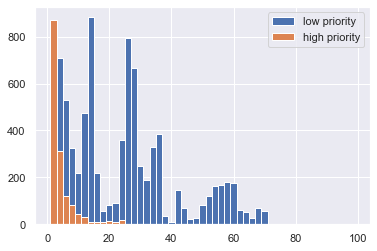

In [42]:
fig, ax = plt.subplots(1, 1)
ax.hist(results_low, bins=np.arange(1, 100, 2), label='low priority')
ax.hist(results_high, bins=np.arange(1, 100, 2), label='high priority')
ax.legend()

In [43]:
pd.DataFrame(results_all).describe()

,0
count,9570.000000
mean,21.489655
std,17.597031
min,1.000000
25%,6.000000
50%,15.000000
75%,30.000000
max,71.000000


In [44]:
pd.DataFrame(results_high).describe()

,0
count,1540.000000
mean,3.769481
std,4.392915
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,25.000000


In [45]:
pd.DataFrame(results_low).describe()

,0
count,8030.000000
mean,24.888045
std,17.133938
min,3.000000
25%,12.000000
50%,25.000000
75%,34.000000
max,71.000000


In [46]:
(results_low < TARGET_LOW).mean()

0.43051058530510583

In [47]:
(results_high < TARGET_HIGH).mean()

0.7688311688311689